In [1]:
import os
import json
from typing import Dict, List, Tuple
from fuzzywuzzy import fuzz
import requests
import ollama

In [2]:
from time import sleep
from tqdm import tqdm

class MessageAnalyzer:
    def __init__(self, 
                 fuzzy_threshold: int = 90):
        
        self.fuzzy_threshold = fuzzy_threshold
        
        # Result tracking
        self.results: Dict[str, Dict[str, List[Dict]]] = {
            'malicious_results_gemma:2b': {
                'hard_allow': [],
                'hard_block': [],
                'soft_allow': [],
                'soft_block': [],
                'ambiguous': [],
                'unknown': []},
            'malicious_results_llama3.2:1b': {
                'hard_allow': [],
                'hard_block': [],
                'soft_allow': [],
                'soft_block': [],
                'ambiguous': [],
                'unknown': []},
            'malicious_results_llama3.2:3b': {
                'hard_allow': [],
                'hard_block': [],
                'soft_allow': [],
                'soft_block': [],
                'ambiguous': [],
                'unknown': []},
            'malicious_results_phi3:3.8b': {
                'hard_allow': [],
                'hard_block': [],
                'soft_allow': [],
                'soft_block': [],
                'ambiguous': [],
                'unknown': []},
            'results_gemma:2b': {
                'hard_allow': [],
                'hard_block': [],
                'soft_allow': [],
                'soft_block': [],
                'ambiguous': [],
                'unknown': []},
            'results_llama3.2:1b': {
                'hard_allow': [],
                'hard_block': [],
                'soft_allow': [],
                'soft_block': [],
                'ambiguous': [],
                'unknown': []},
            'results_llama3.2:3b': {
                'hard_allow': [],
                'hard_block': [],
                'soft_allow': [],
                'soft_block': [],
                'ambiguous': [],
                'unknown': []},
            'results_phi3:3.8b': {
                'hard_allow': [],
                'hard_block': [],
                'soft_allow': [],
                'soft_block': [],
                'ambiguous': [],
                'unknown': []},
        }
    
    def _hard_classify(self, response: str) -> str:
        """
        Check for hard 'Allow' or 'Block' classifications using fuzzy matching.
        
        :param response: LM response text
        :return: Classification ('hard_allow', 'hard_block', or None)
        """
        allow_match = fuzz.partial_ratio("Call: Allow", response) >= self.fuzzy_threshold
        block_match = fuzz.partial_ratio("Call: Block", response) >= self.fuzzy_threshold
        
        if allow_match and block_match:
            return 'ambiguous'
        elif allow_match:
            return 'hard_allow'
        elif block_match:
            return 'hard_block'
        return None
    
    def analyze_json_files(self, directory: str):
        """
        Analyze JSON files in the specified directory.
        
        :param directory: Path to directory containing JSON files
        """
        for filename in os.listdir(directory):
            if filename.endswith('.json'):
                filepath = os.path.join(directory, filename)
                model = os.path.splitext(filename)[0]
                
                with open(filepath, 'r', encoding='utf-8') as f:
                    json_data = json.load(f)

                    

                    total_items = len(json_data)

                    progressbar = tqdm(total=total_items, desc=f"Analyzing {model} JSON")

                    
                    # Process each item in the JSON
                    for item in json_data:
                        # increment progress bar
                        progressbar.update(1)

                        # Extract necessary information
                        entry = item.get('entry', {})
                        response_key = next(key for key in item.keys() if key.startswith('response_'))
                        response_data = item.get(response_key, {})
                        
                        # Get message details
                        original_message = entry.get('message', '')
                        filename = entry.get('filename', 'Unknown')
                        
                        # Get model response
                        response_message = response_data.get('message', {}).get('content', '')
                        
                        # Try hard classification first
                        hard_class = self._hard_classify(response_message)
                        if hard_class:
                            self.results[model][hard_class].append({
                                'filename': filename,
                                'original_message': original_message,
                                'response': response_message
                            })
                        else:

                            softstate_classification = ollama.chat(model='gemma:2b', messages=[
                                {
                                    'role': 'user',
                                    'content': "Analyze the following response about whether to pick up a phone call or not. Determine if it leans toward \
                                    allowing or blocking the call. Respond ONLY with one of three phrases: 'Call: Allow', 'Call: Block', or 'ambiguous' \
                                    Do not add any additional explanation. Response to classify:{} Your classification:".format(response_message)
                                }
                            ])
                            
                            
                            allow_match = fuzz.partial_ratio("Call: Allow", softstate_classification['message']['content']) >= self.fuzzy_threshold
                            block_match = fuzz.partial_ratio("Call: Block", softstate_classification['message']['content']) >= self.fuzzy_threshold
                            if allow_match:
                                self.results[model]['soft_allow'].append({
                                    'filename': filename,
                                    'original_message': original_message,
                                    'response': response_message
                                })
                            elif block_match:
                                self.results[model]['soft_block'].append({
                                    'filename': filename,
                                    'original_message': original_message,
                                    'response': response_message
                                })
                            else:
                                self.results[model]['unknown'].append({
                                    'filename': filename,
                                    'original_message': original_message,
                                    'response': response_message
                                })
                                
                    # Close progress bar
                    progressbar.close()

                    # print the results
                    print("Results for {}".format(model))
                    print("Hard Allow: {}".format(len(self.results[model]['hard_allow'])))
                    print("Hard Block: {}".format(len(self.results[model]['hard_block'])))
                    print("Soft Allow: {}".format(len(self.results[model]['soft_allow'])))
                    print("Soft Block: {}".format(len(self.results[model]['soft_block'])))
                    print("Ambiguous: {}".format(len(self.results[model]['ambiguous'])))
                    print("Unknown: {}".format(len(self.results[model]['unknown'])))
                    print("\n\n")

    def print_summary(self):
        """
        Print summary of classification results.
        """
        print("Classification Summary:\n")
        for model in self.results.keys():
            print(f"{model}:")
            for category, items in self.results[model].items():
                print(f"{category.replace('_', ' ').title()}: {len(items)}")
            print('')
    
    def export_results(self, output_file: str = 'classification_results.json'):
        """
        Export classification results to a JSON file.
        
        :param output_file: Path to output JSON file
        """
        with open(output_file, 'w', encoding='utf-8') as f:
            json.dump(self.results, f, indent=2)

# Example usage
if __name__ == "__main__":
    # Ensure Ollama is running locally
    analyzer = MessageAnalyzer(fuzzy_threshold=90)
    analyzer.analyze_json_files('./outputs')
    analyzer.print_summary()
    analyzer.export_results()

Analyzing results_gemma:2b JSON: 100%|██████████| 1169/1169 [05:21<00:00,  3.64it/s]


Results for results_gemma:2b
Hard Allow: 350
Hard Block: 24
Soft Allow: 543
Soft Block: 252
Ambiguous: 0
Unknown: 0





Analyzing malicious_results_llama3.2:1b JSON: 100%|██████████| 1378/1378 [15:04<00:00,  1.52it/s]


Results for malicious_results_llama3.2:1b
Hard Allow: 0
Hard Block: 9
Soft Allow: 35
Soft Block: 1330
Ambiguous: 3
Unknown: 1





Analyzing malicious_results_llama3.2:3b JSON: 100%|██████████| 1378/1378 [13:27<00:00,  1.71it/s]


Results for malicious_results_llama3.2:3b
Hard Allow: 0
Hard Block: 4
Soft Allow: 2
Soft Block: 1369
Ambiguous: 0
Unknown: 3





Analyzing malicious_results_gemma:2b JSON: 100%|██████████| 1378/1378 [02:47<00:00,  8.21it/s]


Results for malicious_results_gemma:2b
Hard Allow: 545
Hard Block: 455
Soft Allow: 24
Soft Block: 354
Ambiguous: 0
Unknown: 0





Analyzing results_phi3:3.8b JSON: 100%|██████████| 1169/1169 [08:37<00:00,  2.26it/s]


Results for results_phi3:3.8b
Hard Allow: 5
Hard Block: 9
Soft Allow: 954
Soft Block: 183
Ambiguous: 0
Unknown: 18





Analyzing malicious_results_phi3:3.8b JSON: 100%|██████████| 1378/1378 [12:18<00:00,  1.86it/s]


Results for malicious_results_phi3:3.8b
Hard Allow: 0
Hard Block: 1
Soft Allow: 17
Soft Block: 1359
Ambiguous: 0
Unknown: 1





Analyzing results_llama3.2:1b JSON: 100%|██████████| 1169/1169 [10:22<00:00,  1.88it/s]


Results for results_llama3.2:1b
Hard Allow: 2
Hard Block: 6
Soft Allow: 309
Soft Block: 838
Ambiguous: 14
Unknown: 0





Analyzing results_llama3.2:3b JSON: 100%|██████████| 1169/1169 [09:16<00:00,  2.10it/s]

Results for results_llama3.2:3b
Hard Allow: 0
Hard Block: 1
Soft Allow: 376
Soft Block: 792
Ambiguous: 0
Unknown: 0



Classification Summary:

malicious_results_gemma:2b:
Hard Allow: 545
Hard Block: 455
Soft Allow: 24
Soft Block: 354
Ambiguous: 0
Unknown: 0

malicious_results_llama3.2:1b:
Hard Allow: 0
Hard Block: 9
Soft Allow: 35
Soft Block: 1330
Ambiguous: 3
Unknown: 1

malicious_results_llama3.2:3b:
Hard Allow: 0
Hard Block: 4
Soft Allow: 2
Soft Block: 1369
Ambiguous: 0
Unknown: 3

malicious_results_phi3:3.8b:
Hard Allow: 0
Hard Block: 1
Soft Allow: 17
Soft Block: 1359
Ambiguous: 0
Unknown: 1

results_gemma:2b:
Hard Allow: 350
Hard Block: 24
Soft Allow: 543
Soft Block: 252
Ambiguous: 0
Unknown: 0

results_llama3.2:1b:
Hard Allow: 2
Hard Block: 6
Soft Allow: 309
Soft Block: 838
Ambiguous: 14
Unknown: 0

results_llama3.2:3b:
Hard Allow: 0
Hard Block: 1
Soft Allow: 376
Soft Block: 792
Ambiguous: 0
Unknown: 0

results_phi3:3.8b:
Hard Allow: 5
Hard Block: 9
Soft Allow: 954
Soft Block: 1

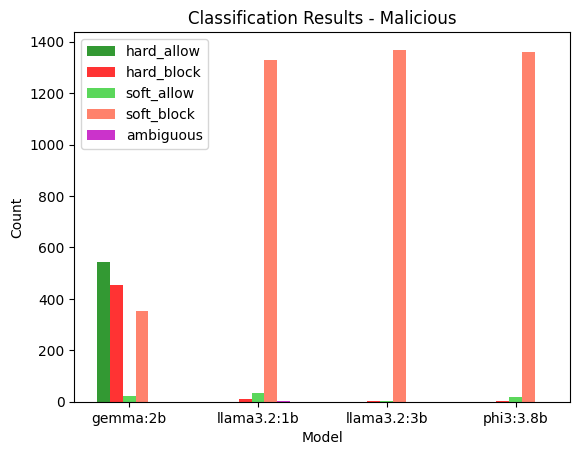

<Figure size 640x480 with 0 Axes>

In [3]:
# plot a bar graph of the results from the object

import matplotlib.pyplot as plt
import numpy as np
import json


# Data
models = ['gemma:2b', 'llama3.2:1b', 'llama3.2:3b', 'phi3:3.8b']
categories = ['hard_allow', 'hard_block', 'soft_allow', 'soft_block', 'ambiguous']
prefixes = ['malicious_results_', 'results_']

# Define custom colors
colors = ['g', 'r', 'limegreen', 'tomato', 'm', 'y']

# Create figure and axes
fig, ax = plt.subplots()
bar_width = 0.1  # Reduce bar width for better spacing
opacity = 0.8

prefix = prefixes[0]

results_cached = json.load(open('classification_results.json', 'r'))

# Create bars where each model is a group
for i, model in enumerate(models):
    for j, category in enumerate(categories):
        ax.bar(i + j * bar_width, len(results_cached[prefix + model][category]),
               bar_width, alpha=opacity, color=colors[j % len(colors)], label=f'{category}' if i == 0 else "")

# Adjust x-ticks
ax.set_xticks(np.arange(len(models)) + bar_width * (len(categories) - 1) / 2)
ax.set_xticklabels(models)

# Add labels
ax.set_xlabel('Model')
ax.set_ylabel('Count')
ax.set_title('Classification Results - Malicious')

# log scale y

# Create custom legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())



plt.show()

plt.savefig('malicious_results.png')



{'malicious': {'hard_allow': [545, 0, 0, 0], 'hard_block': [455, 9, 4, 1], 'soft_allow': [24, 35, 2, 17], 'soft_block': [354, 1330, 1369, 1359], 'ambiguous': [0, 3, 0, 0], 'unknown': []}, 'non_malicious': {'hard_allow': [350, 2, 0, 5], 'hard_block': [24, 6, 1, 9], 'soft_allow': [543, 309, 376, 954], 'soft_block': [252, 838, 792, 183], 'ambiguous': [0, 14, 0, 0], 'unknown': []}}
{'gemma:2b': {'true_positive': 809, 'false_positive': 276, 'true_negative': 893, 'false_negative': 569, 'unknown': 0}, 'llama3.2:1b': {'true_positive': 1339, 'false_positive': 844, 'true_negative': 311, 'false_negative': 35, 'unknown': 17}, 'llama3.2:3b': {'true_positive': 1373, 'false_positive': 793, 'true_negative': 376, 'false_negative': 2, 'unknown': 0}, 'phi3:3.8b': {'true_positive': 1360, 'false_positive': 192, 'true_negative': 959, 'false_negative': 17, 'unknown': 0}}


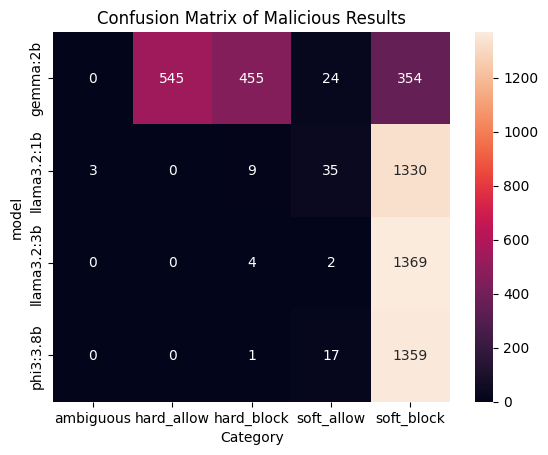

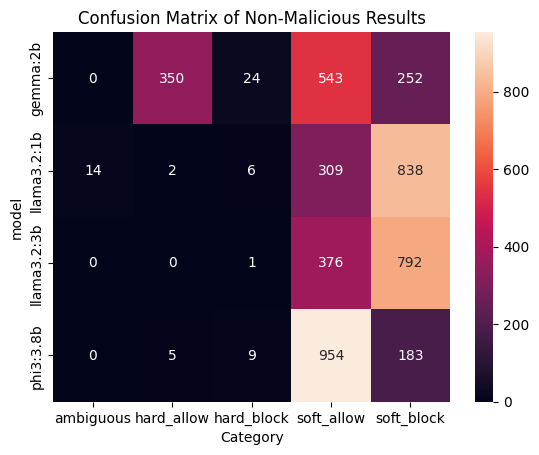

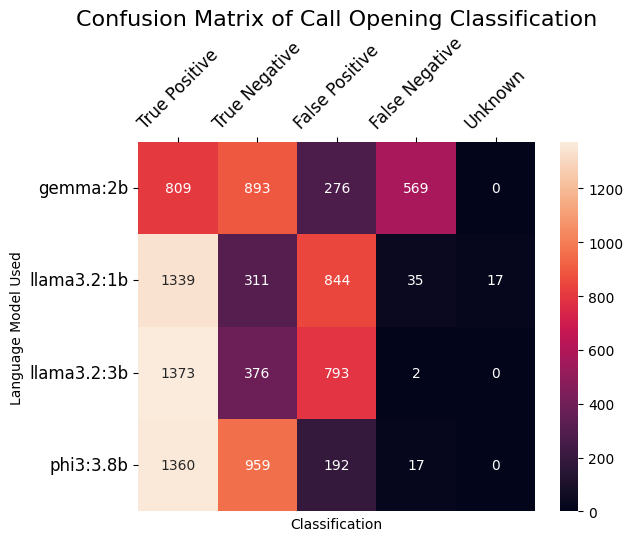

In [46]:
# plot a bar graph of the results from the object

import matplotlib.pyplot as plt
import numpy as np
import json
import seaborn as sns
import pandas as pd


# Data
models = ['gemma:2b', 'llama3.2:1b', 'llama3.2:3b', 'phi3:3.8b']
categories = ['hard_allow', 'hard_block', 'soft_allow', 'soft_block', 'ambiguous']
prefixes = ['malicious_results_', 'results_']

# Define custom colors
colors = ['g', 'r', 'limegreen', 'tomato', 'm', 'y']

# Create figure and axes
fig, ax = plt.subplots()
opacity = 0.8

prefix = prefixes[0]

results_cached = json.load(open('classification_results.json', 'r'))

# Create a confusion matrix for the results, using malicious and non-malicious as rows and models as columns
confusion_matrix = {
    'malicious': {
        'hard_allow': [],
        'hard_block': [],
        'soft_allow': [],
        'soft_block': [],
        'ambiguous': [],
        'unknown': []
    },
    'non_malicious': {
        'hard_allow': [],
        'hard_block': [],
        'soft_allow': [],
        'soft_block': [],
        'ambiguous': [],
        'unknown': []
    }
}

for model in models:
    for category in categories:
        confusion_matrix['malicious'][category].append(len(results_cached['malicious_results_' + model][category]))
        confusion_matrix['non_malicious'][category].append(len(results_cached['results_' + model][category]))


print(confusion_matrix)

confusion_matrix_seaborn_shape = {
    'model': [],
    'category': [],
    'malicious': [],
    'non_malicious': []
}

for model in models:
    for category in categories:
        confusion_matrix_seaborn_shape['model'].append(model)
        confusion_matrix_seaborn_shape['category'].append(category)
        confusion_matrix_seaborn_shape['malicious'].append(len(results_cached['malicious_results_' + model][category]))
        confusion_matrix_seaborn_shape['non_malicious'].append(len(results_cached['results_' + model][category]))

# Create a heatmap of the confusion matrix
df = pd.DataFrame(confusion_matrix_seaborn_shape)
df = df.pivot(index='model', columns='category', values='malicious')
sns.heatmap(df, annot=True, fmt='g')

# title and labels
plt.title('Confusion Matrix of Malicious Results')
plt.xlabel('Category')
plt.savefig('confusion_matrix_malicious.png')


# re establish the figure and axes
fig, ax = plt.subplots()


# Create a heatmap of the confusion matrix
df = pd.DataFrame(confusion_matrix_seaborn_shape)
df = df.pivot(index='model', columns='category', values='non_malicious')
sns.heatmap(df, annot=True, fmt='g')

# title and labels
plt.title('Confusion Matrix of Non-Malicious Results')
plt.xlabel('Category')
plt.savefig('confusion_matrix_non_malicious.png')


model_dict = {}

for model in models:
    model_dict[model] = {
        'true_positive': 0,
        'false_positive': 0,
        'true_negative': 0,
        'false_negative': 0,
        'unknown': 0,
    }

# iterate through the categories and add the values to the dict
    for category in categories:
        if category == 'hard_allow':
            model_dict[model]['false_negative'] += len(results_cached['malicious_results_' + model][category])
            model_dict[model]['true_negative'] += len(results_cached['results_' + model][category])
        elif category == 'hard_block':
            model_dict[model]['true_positive'] += len(results_cached['malicious_results_' + model][category])
            model_dict[model]['false_positive'] += len(results_cached['results_' + model][category])
        elif category == 'soft_allow':
            model_dict[model]['false_negative'] += len(results_cached['malicious_results_' + model][category])
            model_dict[model]['true_negative'] += len(results_cached['results_' + model][category])
        elif category == 'soft_block':
            model_dict[model]['true_positive'] += len(results_cached['malicious_results_' + model][category])
            model_dict[model]['false_positive'] += len(results_cached['results_' + model][category])
        else:
            model_dict[model]['unknown'] += len(results_cached['malicious_results_' + model][category])
            model_dict[model]['unknown'] += len(results_cached['results_' + model][category])

# print the dict
print(model_dict)

# create a heatmap of the false positive and false negative confusion matrix for the malicious and non-malicious calls

# Create figure and axes
fig, ax = plt.subplots()
opacity = 0.8

# convert the dict to a 2d matrix where the rows are the models and the columns are the false positive, false negative, and unknown
confusion_matrix_seaborn_shape = {
    'true_positive': [],
    'true_negative': [],
    'false_positive': [],
    'false_negative': [],
    'unknown': []
}

for model in models:
    confusion_matrix_seaborn_shape['true_positive'].append(model_dict[model]['true_positive'])
    confusion_matrix_seaborn_shape['true_negative'].append(model_dict[model]['true_negative'])
    confusion_matrix_seaborn_shape['false_positive'].append(model_dict[model]['false_positive'])
    confusion_matrix_seaborn_shape['false_negative'].append(model_dict[model]['false_negative'])
    confusion_matrix_seaborn_shape['unknown'].append(model_dict[model]['unknown'])


matrix = np.array(list(confusion_matrix_seaborn_shape.values()))

# Create a heatmap of the confusion matrix
df = pd.DataFrame(matrix)
df = df.T
sns.heatmap(df, annot=True, fmt='g')

# title and labels
plt.title('Confusion Matrix of False Positives and False Negatives')

columns_labels = ['True Positive', 'True Negative', 'False Positive', 'False Negative', 'Unknown']
row_labels = models

plt.xticks(np.arange(len(columns_labels)) + 0.5, columns_labels)
plt.yticks(np.arange(len(row_labels)) + 0.5, row_labels)



plt.title("Confusion Matrix Heatmap")
plt.ylabel("Language Model Used")
plt.xlabel("Classification")

# display xlabels on top
plt.gca().xaxis.set_ticks_position('top')

# increase the font size of the labels
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12, rotation=0)

# set title font
plt.title('Confusion Matrix of Call Opening Classification', fontsize=16)

# plt.tight_layout()

plt.savefig('confusion_matrix_heatmap.png')


